# Plotting the result of a sparql query

## Install & imports

```bash
conda create -n sparql python=3.7
conda activate sparql
conda install -y pandas jupyterlab 
conda install -y scipy matplotlib
conda install -y sparqlwrapper
conda install -y networkx
pip install Wikidata
conda install -c ostrokach-forge graph-tool
```

In [1]:
from SPARQLWrapper import SPARQLWrapper, JSON
import numpy as np
import pandas as pd
from wikidata.client import Client
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import math
import graph_tool
import graph_tool.all as gt

client = Client()

## Query

In [2]:
endpoint_url = "https://query.wikidata.org/sparql"
query = """PREFIX gas: <http://www.bigdata.com/rdf/gas#>
SELECT ?item ?itemLabel ?linkTo ?size {
  { SELECT ?item (count(distinct ?element) as ?size) {
  SERVICE gas:service {
    gas:program gas:gasClass "com.bigdata.rdf.graph.analytics.SSSP" ;
                gas:in wd:Q11660 ;
                gas:traversalDirection "Undirected" ;
                gas:out ?item ;
                gas:out1 ?depth ;
                gas:maxIterations 2 ;
                gas:maxVisited 2 ;
                gas:linkType wdt:P361 .
  }
  OPTIONAL { ?element wdt:P921 ?item }
  } GROUP BY ?item }
  OPTIONAL { ?item wdt:P361 ?linkTo }
  SERVICE wikibase:label {bd:serviceParam wikibase:language "en" }
}"""

In [3]:
def get_results(endpoint_url, query):
    sparql = SPARQLWrapper(endpoint_url)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()

results = get_results(endpoint_url, query)
bindings = results['results']['bindings']

## Filling a dataframe with the query result

In [4]:
data = []
for r in bindings: 
    d = {}
    d['item'] = r['item']['value']
    d['size'] = r['size']['value']
    try:
        d['linkTo'] = r['linkTo']['value']
    except:
        d['linkTo'] = None
    d['label'] = r['itemLabel']['value']
    data.append(d)
df = pd.DataFrame(data=data)

## Creating an edge dataframe

In [5]:
nodes = pd.concat([df['item'], df['linkTo']], axis=0).to_frame('item')
nodes = pd.merge(nodes, df[['item', 'label']], on='item', how='left')
nodes.drop_duplicates(inplace=True)
nodes.reset_index(drop=True, inplace=True)
nodes.dropna(subset=['item'], inplace=True)
nodes['code'] = nodes.item.map(lambda s: s.split('/')[-1])
nodes = pd.merge(nodes, df[['item', 'size']].drop_duplicates(), on='item', how='left')
nodes['size'] = nodes['size'].astype(float)
nodes.sort_values(by='size', inplace=True, ascending=False)
nodes.reset_index(drop=True, inplace=True)
nodes['size'] = nodes['size'].fillna(0.)
nodes['size'] += 1.
nodes.head(2)

,item,label,code,size
0,http://www.wikidata.org/entity/Q2539,machine learning,Q2539,4964.0
1,http://www.wikidata.org/entity/Q2878974,theoretical computer science,Q2878974,2393.0


### Some node labels are missing

In [6]:
print(len(nodes), len(nodes[nodes.label.isna()]))

100 29


In [7]:
def get_label(code):
    entity = client.get(code, load=True)
    return entity.label.texts.get('en', None)

nodes['label_new'] = nodes.code.map(lambda s: get_label(s))
nodes.loc[nodes.label_new.isna(), 'label_new'] = nodes.loc[nodes.label_new.isna(), 'code']
nodes.drop('label', axis=1, inplace=True)
nodes.rename(columns={'label_new': 'label'}, inplace=True)

In [8]:
edges = df[['item', 'linkTo']].copy(deep=True)
edges.dropna(inplace=True)
edges.drop_duplicates(inplace=True)
edges.reset_index(drop=True, inplace=True)

In [9]:
edges = pd.merge(edges, nodes[['item', 'label']], on='item', how='left')
edges.rename(columns={'label': 'source'}, inplace=True)
edges.drop('item', axis=1, inplace=True)
edges = pd.merge(edges, nodes[['item', 'label']], left_on='linkTo', right_on='item', how='left')
edges.rename(columns={'label': 'target'}, inplace=True)
edges.drop(['item', 'linkTo'], axis=1, inplace=True)
edges.head(2)

,source,target
0,machine learning,artificial intelligence
1,algorithm,mathematics


## From Pandas to Networkx

/home/francois/anaconda3/envs/sparql/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


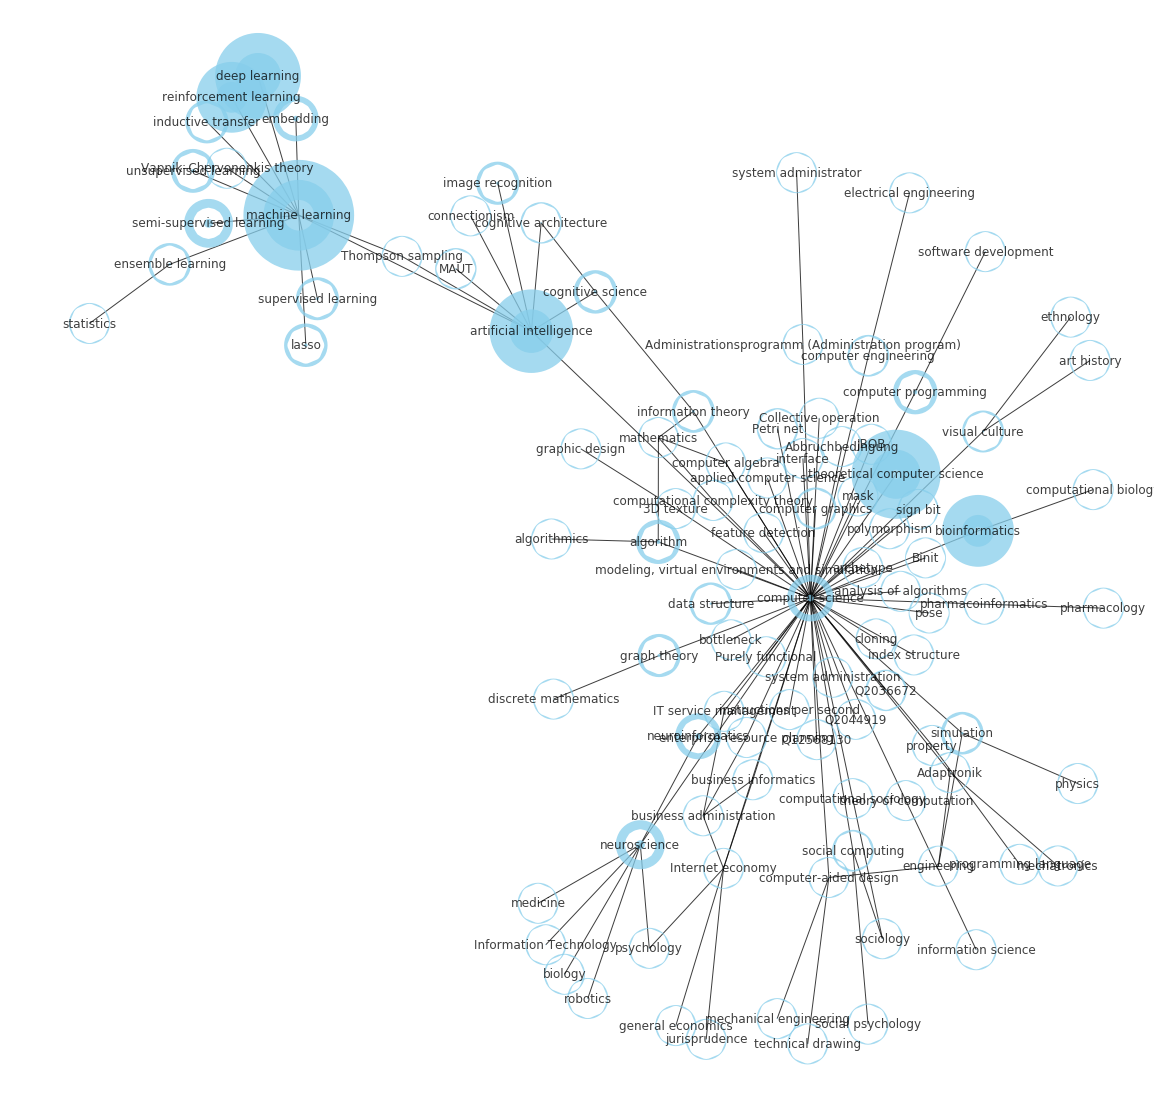

In [10]:
G = nx.from_pandas_edgelist(edges, 'source', 'target')
pos = nx.spring_layout(G, iterations=100, seed=1234, k=3./math.sqrt(G.order()));

plt.figure(figsize=(20, 20));
# nx.draw_networkx(G, pos, with_labels=True, node_size=500, node_color="skyblue", node_shape="o", alpha=0.5, linewidths=40);
node_list = nodes.label.values.tolist()
node_size = nodes['size'].values.copy() 
node_size /= np.max(node_size)
node_size *= 5000.
node_size += 0.1
node_size = list(node_size)
nx.draw_networkx(G, pos, with_labels=True, nodelist=node_list, node_size=node_size,
                 node_color="skyblue", node_shape="o", alpha=0.75, linewidths=40);
plt.axis('off');

## From Pandas to Graph-tool

In [11]:
G = gt.Graph(directed=False)

In [12]:
node_dict = {}
node_label = {}
node_size = {}
for row in nodes.itertuples():
    v = G.add_vertex()
    node_dict[row.label] = v
    node_label[v] = row.label
    node_size[v] = row.size

In [13]:
for row in edges.itertuples():
    v1, v2 = node_dict[row.source], node_dict[row.target]
    _ = G.add_edge(v1, v2)

In [14]:
G.vertex_properties["vertex_size"] = G.new_vertex_property("double")
G.vertex_properties["vertex_label"] = G.new_vertex_property("string")

In [15]:
G.list_properties()

vertex_label   (vertex)  (type: string)
vertex_size    (vertex)  (type: double)


In [16]:
for v in G.vertices():
    G.vertex_properties["vertex_label"][v] = node_label[v]
    G.vertex_properties["vertex_size"][v] = node_size[v]

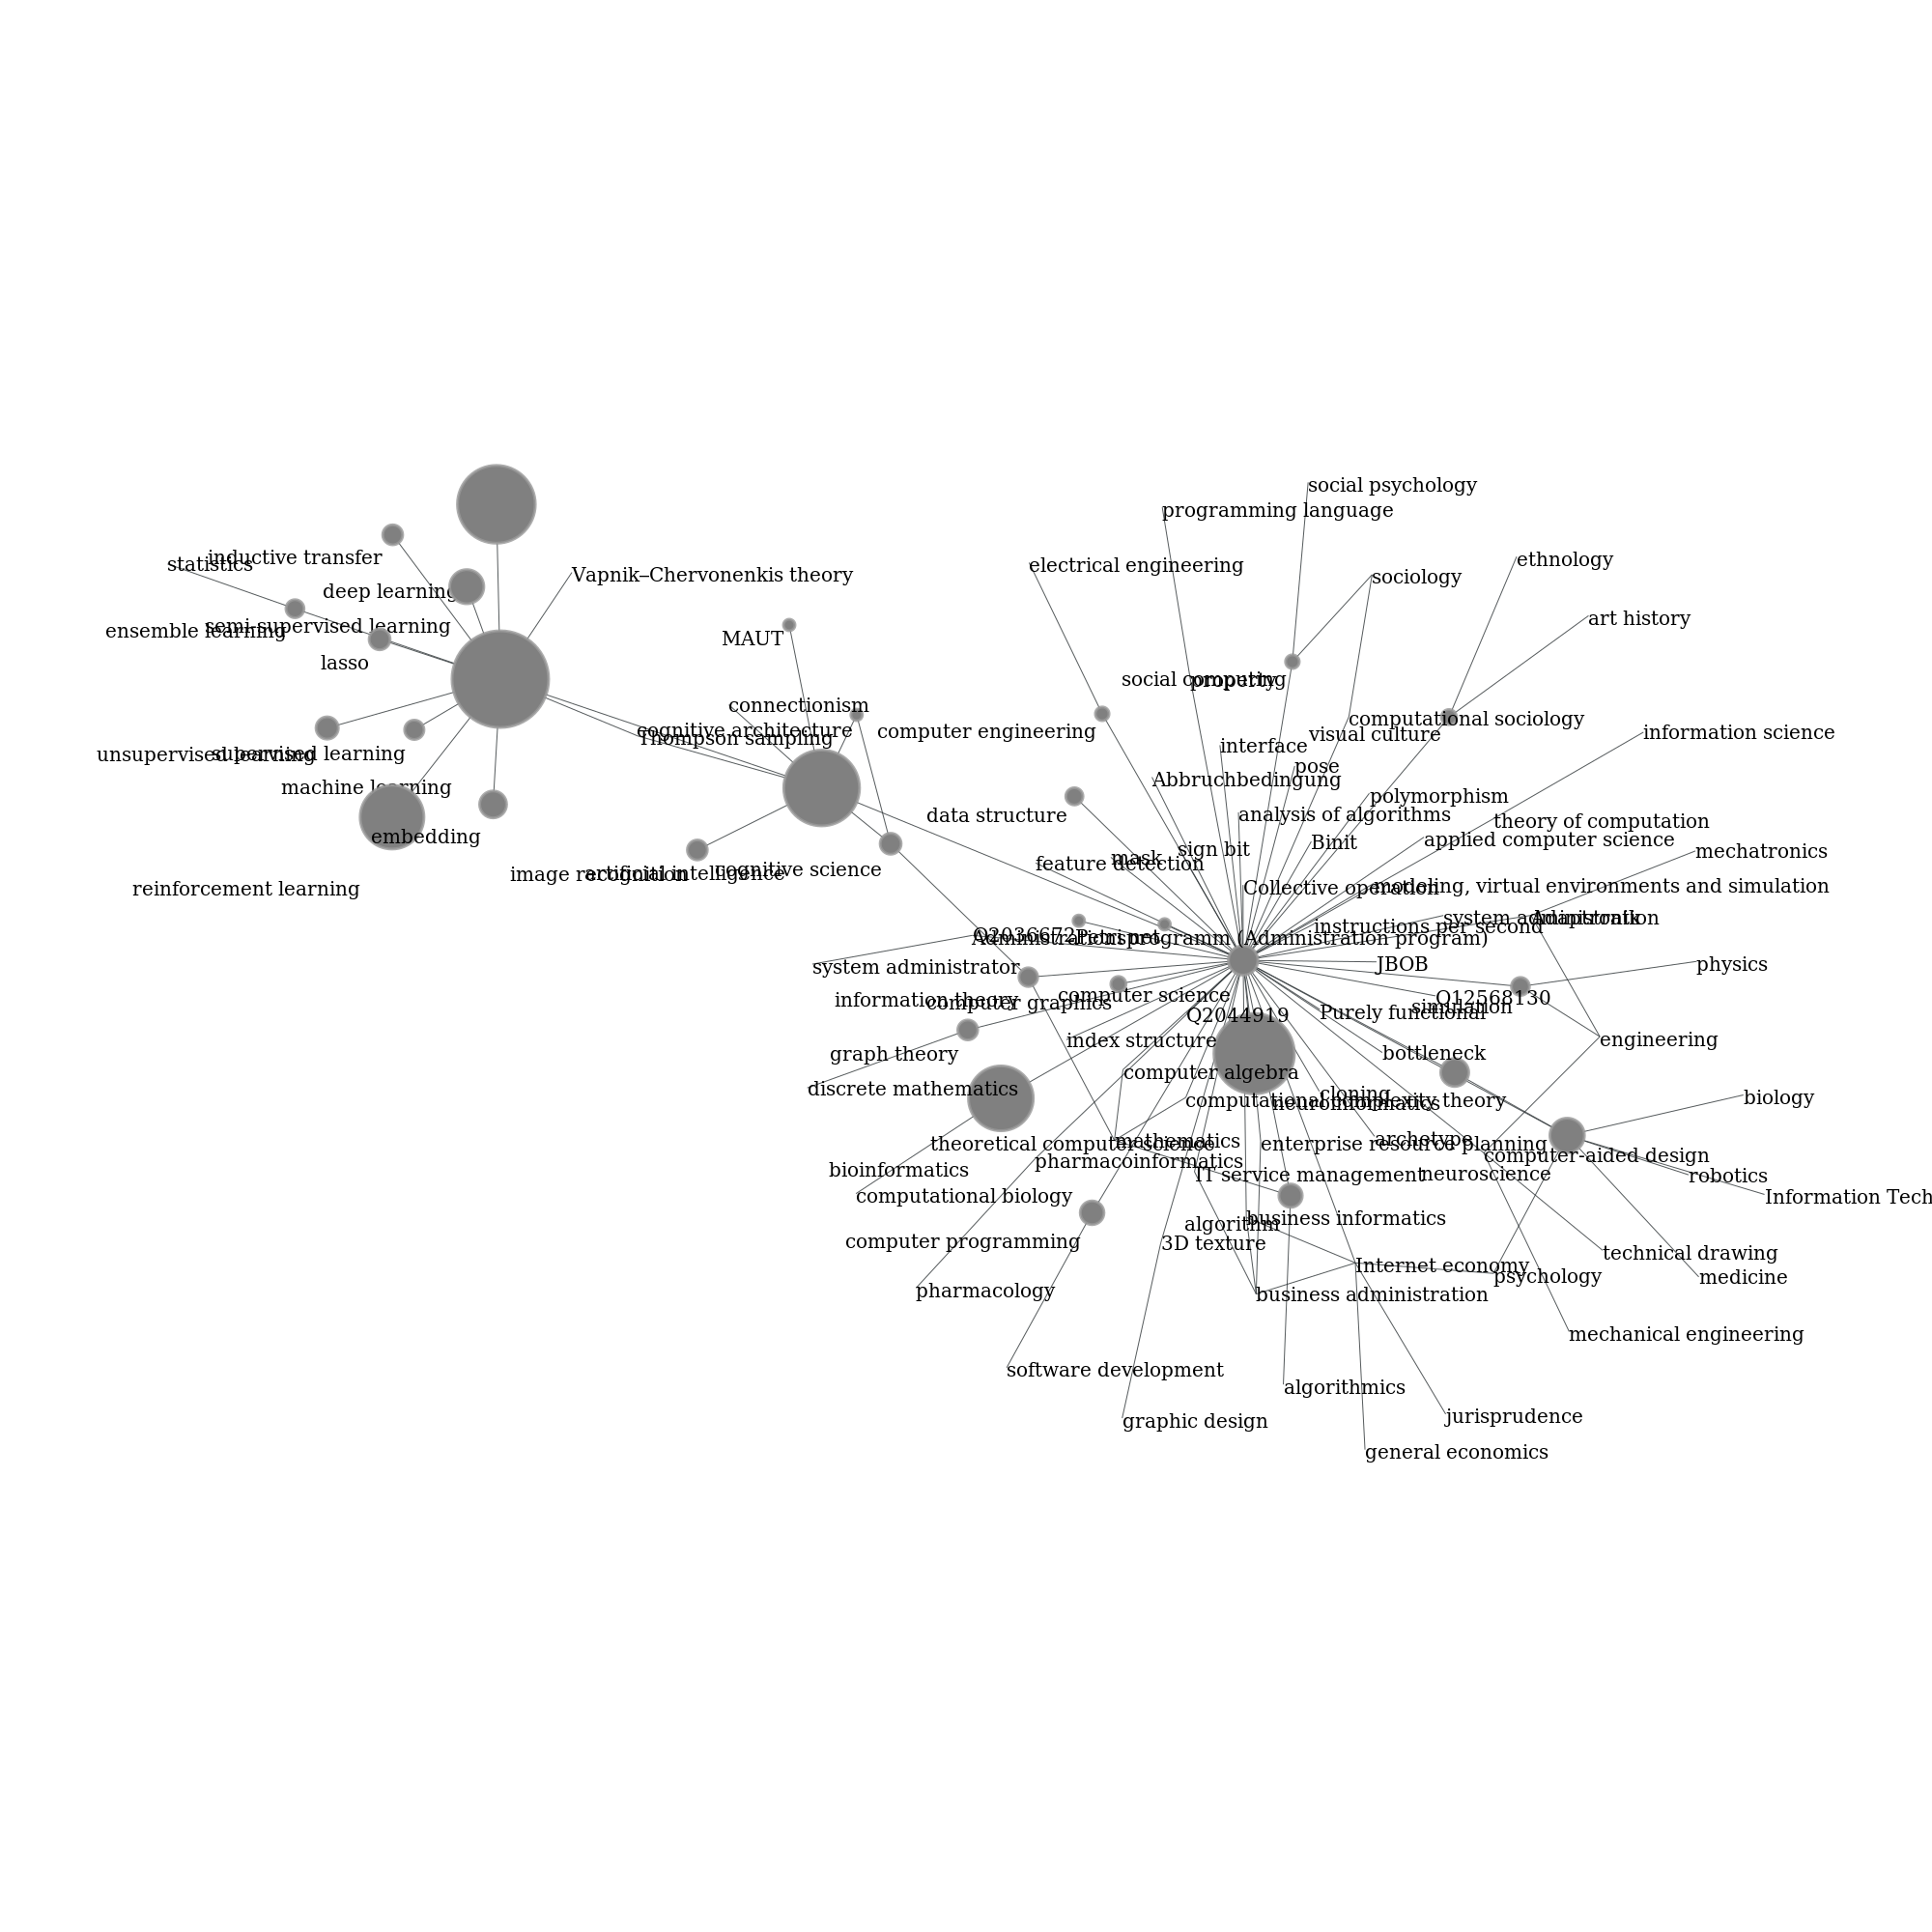

In [17]:
pos = graph_tool.draw.sfdp_layout(G)
v_size = graph_tool.draw.prop_to_size(G.vertex_properties["vertex_size"], mi=0, ma=100, log=False, power=0.25)
gt.graph_draw(G, pos=pos, 
              vertex_text=G.vertex_properties["vertex_label"], vertex_font_size=20, vertex_text_position=2, vertex_size=v_size,
              vertex_fill_color="grey", vertex_pen_width=3, output_size=(2000,2000),
              vertex_halo=False);